In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST

Populating the interactive namespace from numpy and matplotlib


## Configuration

In [2]:
BATCH_SIZE = 32

## Data (MNIST)

In [3]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

## Model Discriminator

### Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(784, 548)
        self.fc2 = nn.Linear(548, 252)
        self.fc3 = nn.Linear(252, 2)
        
        self.bc1 = nn.BatchNorm1d(548)
        self.bc2 = nn.BatchNorm1d(252)
                
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.sigmoid(h)
        return out

D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

Discriminator (
  (fc1): Linear (784 -> 548)
  (fc2): Linear (548 -> 252)
  (fc3): Linear (252 -> 2)
  (bc1): BatchNorm1d(548, eps=1e-05, momentum=0.1, affine=True)
  (bc2): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True)
)


### Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(100, 196)
        self.fc2 = nn.Linear(196, 289)
        self.fc3 = nn.Linear(289, 361)
        self.fc4 = nn.Linear(361, 529)
        self.fc5 = nn.Linear(529, 784)
        
        self.bc1 = nn.BatchNorm1d(196)
        self.bc2 = nn.BatchNorm1d(289)
        self.bc3 = nn.BatchNorm1d(361)
        self.bc4 = nn.BatchNorm1d(529)
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.3, training=self.training)
        
        h = self.fc3(h)
        h = self.bc3(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc4(h)
        h = self.bc4(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc5(h)
        out = F.sigmoid(h)
        return out

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator (
  (fc1): Linear (100 -> 196)
  (fc2): Linear (196 -> 289)
  (fc3): Linear (289 -> 361)
  (fc4): Linear (361 -> 529)
  (fc5): Linear (529 -> 784)
  (bc1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True)
  (bc2): BatchNorm1d(289, eps=1e-05, momentum=0.1, affine=True)
  (bc3): BatchNorm1d(361, eps=1e-05, momentum=0.1, affine=True)
  (bc4): BatchNorm1d(529, eps=1e-05, momentum=0.1, affine=True)
)


## Train

* $ [0, 1]$ : real images
* $[1, 0]$ : fake images

In [6]:
real_y = torch.zeros((BATCH_SIZE, 2))
real_y[:, 1] = 1
real_y = Variable(real_y.cuda())

fake_y = torch.zeros((BATCH_SIZE, 2))
fake_y[:, 0] = 1
fake_y = Variable(fake_y.cuda())

loss_f = nn.BCELoss()

In [41]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
for epoch in range(10):
    for step, (real_images, _) in enumerate(train_loader):
        real_images = Variable(real_images.cuda())

        # Init D
        d_optimizer.zero_grad()

        ###############################################
        # Train D with real images
        ###############################################
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y)
        d_real_loss.backward()
        d_optimizer.step()

        ###############################################
        # Train D with fake images but do not train G
        ###############################################
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions).detach()
        y_pred = D(fake_images)
        d_fake_loss = loss_f(y_pred, fake_y)
        d_fake_loss.backward()
        d_optimizer.step()

        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions)
        y_pred = D(fake_images)
        g_loss = loss_f(y_pred, real_y)
        g_loss.backward()
        g_optimizer.step()
        
        if step % 200 == 0:
            print(f'\rEpoch:[{epoch}] Step:[{step}] -',
                  '[D_real_loss]: {:.4}'.format(d_real_loss.data[0]),
                  '[D_fake_loss]: {:.4}'.format(d_fake_loss.data[0]), 
                  '[G_loss]:{:.4}'.format(g_loss.data[0]), end='') 
    print()

Epoch:[0] Step:[1800] - [D_real_loss]: 0.5371 [D_fake_loss]: 0.2362 [G loss]:1.8591
Epoch:[1] Step:[1800] - [D_real_loss]: 0.2333 [D_fake_loss]: 0.5074 [G loss]:2.1714
Epoch:[2] Step:[1800] - [D_real_loss]: 0.03098 [D_fake_loss]: 0.5686 [G loss]:1.193
Epoch:[3] Step:[1800] - [D_real_loss]: 0.2384 [D_fake_loss]: 0.171 [G loss]:2.29887
Epoch:[4] Step:[1800] - [D_real_loss]: 0.1685 [D_fake_loss]: 0.3452 [G loss]:1.88692
Epoch:[5] Step:[1800] - [D_real_loss]: 0.09876 [D_fake_loss]: 0.4257 [G loss]:3.2642
Epoch:[6] Step:[1800] - [D_real_loss]: 0.005399 [D_fake_loss]: 0.1076 [G loss]:2.6515
Epoch:[7] Step:[1800] - [D_real_loss]: 0.09454 [D_fake_loss]: 0.1993 [G loss]:1.397
Epoch:[8] Step:[1800] - [D_real_loss]: 0.08877 [D_fake_loss]: 0.1924 [G loss]:2.011
Epoch:[9] Step:[1800] - [D_real_loss]: 0.928 [D_fake_loss]: 0.03352 [G loss]:2.58876


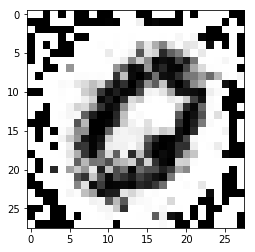

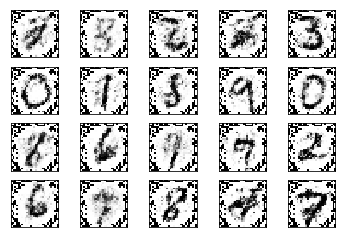

In [45]:
fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
images = G(fake_distributions).view((-1, 28, 28)).data.cpu().numpy()

images[0]
imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(4, 5) # subplots(y축, x축 갯수)

idx = 10
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1
